1. Выполните классификацию набора данных из задания о Байесовской классификации с помощью построения дерева решений, варьируя следующие параметры: критерий выбора атрибута разбиения (entropy, index gini) и соотношение мощностей обучающей и тестовой выборок (от 60%:40% до 90%:10% с шагом 5%). Выполните визуализацию построенных деревьев решений.

Будем использовать датасет, полученный в процессе выполнения л/р 2 "Разметка аудиоданных" по предмету "Анализ аудио видео и графической информации". Датасет содержит информацию о музыкальных произведениях 3600 исполнителей (по 300 исполнителей каждого из 12 жанров популярной музыки: рок, поп, регги, шансон и т.д.). У каждого исполнителя было выбрано по 30 музыкальных произведений, из каждого взяты треки по 10 секунд. Эти музыкальные файлы были представлены в виде мел-кепстальных коэффициентов, к которым 2 раза был применен метод главных компонент с сохранением в коэффициентах 90% дисперсии. 

В итоге, файл genres_pca_100_comp_of_song.csv содержит 100 признаков на каждого из 3600 исполнителей. Ставится задача классифицировать их по 12 жанрам. Для простоты считаем, что каждый из исполнителей исполняет только в одном конкретном жанре.

Будем использовать модель sklearn.tree.DecisionTreeClassifier из библиотеки scikit-learn. DecisionTreeClassifier - это классификатор, способный выполнять мультиклассовую классификацию набора данных.
Здесь я ограничил глубину деревьев значением 10, чтобы избежать переобучения.

In [1]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import graphviz #conda install python-graphviz

In [2]:
#датасет genres_pca_100_comp_of_song.csv   DecisionTreeClassifier

def measure(y_test, y_test_predict, genres):
    #conf matrix
    conf_matrix = pd.DataFrame(np.zeros((12, 12)), index = genres, columns = genres)
    for y, y_p in zip(y_test_predict, y_test):
        conf_matrix.loc[y_p, y] += 1
        
    #accuracy
    accuracy = 0
    for y_p, y in zip(y_test_predict, y_test):
        if y_p == y:
            accuracy += 1
    accuracy /= y_test.shape[0]
    
    #precision
    temp = list()
    for genre in genres:
        temp.append(conf_matrix.loc[genre, genre] / np.sum(conf_matrix.loc[genre, :]))
    precision = np.mean(temp)
    
    #recall
    temp = list()
    for genre in genres:
        temp.append(conf_matrix.loc[genre, genre] / np.sum(conf_matrix.loc[:, genre]))
    recall = np.mean(temp)
    
    #f_measure
    f_measure = 2 * precision * recall / (precision + recall)
  
    return conf_matrix, accuracy, precision, recall, f_measure

if __name__ == '__main__':
    song = pd.read_csv('genres_pca_100_comp_of_song.csv') #genres_pca_mfcc_small.csv
    Y = np.array(song['class'])
    X = np.array(song[[str(i) for i in range(100)]])
    genres = np.unique(Y)
    #print(genres)
    result_table = list()
    for test_size in range(40, 9, -5):
        for criterion in ['gini', 'entropy']:
            print(f'Модель с мощностью обучающей выборки {100 - test_size}%, тестовой выборки {test_size}%')

            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = test_size / 100, shuffle = True, random_state = 42)

            model = tree.DecisionTreeClassifier(random_state=0, criterion = criterion, max_depth = 15)
            model.fit(X_train, y_train)
            
            # визуализация построенных деревьев решений.
            dot_data = tree.export_graphviz(model, max_depth = 3, out_file=None, class_names=genres, filled=True)
            graph = graphviz.Source(dot_data, format="jpg") 
            graph.render('pictures\\dtree100_render_'+ str(test_size)+'_'+criterion, view=False)
            
            print(f'Глубина построенного дерева решений: {model.get_depth()}')
            y_test_predict = model.predict(X_test)
            confusion_matrix, accuracy, precision, recall, f_measure = measure(y_test, y_test_predict, genres)
            print(f'confusion_matrix \n{confusion_matrix}\n accuracy = {accuracy}\n' +
                  f' precision = {precision}\n recall = {recall}\n f_measure = {f_measure}\n')
            result_table.append([criterion, test_size, accuracy, precision, recall, f_measure])

    result = pd.DataFrame(result_table, columns = ['criterion', 'test_size', 'accuracy', 'precision', 'recall', 'f_measure'])
    result.to_csv("result_measure_100.csv")
    print(result)    

Модель с мощностью обучающей выборки 60%, тестовой выборки 40%
Глубина построенного дерева решений: 15
confusion_matrix 
                allrock  blues  country  electronic  hip-hop  jazz  \
allrock            20.0   14.0     12.0        12.0      7.0   2.0   
blues              14.0   17.0     27.0         8.0      6.0   7.0   
country            20.0   11.0     12.0        13.0     12.0   4.0   
electronic         12.0    4.0     11.0         9.0     10.0  10.0   
hip-hop            12.0    7.0     11.0         9.0     10.0   4.0   
jazz                2.0   13.0      6.0         8.0     10.0  26.0   
latin-american      6.0    6.0      9.0         9.0      7.0   9.0   
pop                 6.0    2.0     12.0         9.0     12.0   3.0   
r-n-b               8.0    9.0     12.0         5.0      9.0   4.0   
reggae             10.0    8.0     12.0         9.0      9.0   7.0   
shanson             3.0    1.0     11.0         7.0      6.0   3.0   
world               7.0   11.0     10.0


Модель с мощностью обучающей выборки 70%, тестовой выборки 30%
Глубина построенного дерева решений: 15
confusion_matrix 
                allrock  blues  country  electronic  hip-hop  jazz  \
allrock            16.0   11.0      5.0         5.0     12.0   4.0   
blues              13.0   14.0      9.0         8.0      2.0   8.0   
country            10.0    6.0      8.0         8.0      5.0   6.0   
electronic          4.0   13.0      6.0        12.0      3.0   3.0   
hip-hop             8.0    5.0      3.0         7.0      5.0   2.0   
jazz                5.0    8.0      8.0         4.0      5.0  21.0   
latin-american      4.0    3.0      6.0         8.0      6.0   3.0   
pop                 5.0    4.0      3.0         6.0     11.0   2.0   
r-n-b               5.0    2.0      7.0         4.0     12.0   4.0   
reggae              5.0    8.0      6.0         8.0      8.0   9.0   
shanson             8.0    0.0      1.0         7.0      3.0   5.0   
world              10.0    6.0      7.

Глубина построенного дерева решений: 15
confusion_matrix 
                allrock  blues  country  electronic  hip-hop  jazz  \
allrock            13.0    9.0      7.0         3.0      4.0   0.0   
blues               6.0   12.0     10.0         7.0      4.0   5.0   
country             4.0    8.0      9.0         4.0      8.0   5.0   
electronic          2.0    3.0      3.0         5.0      7.0   2.0   
hip-hop             3.0    2.0      3.0         4.0      5.0   3.0   
jazz                3.0    9.0      4.0         2.0      2.0  18.0   
latin-american      3.0    2.0      2.0         6.0      5.0   3.0   
pop                 1.0    0.0      3.0         2.0      3.0   1.0   
r-n-b               3.0    5.0      1.0         5.0      9.0   2.0   
reggae              2.0    0.0      2.0         1.0      4.0   3.0   
shanson             0.0    0.0      2.0         2.0      3.0   1.0   
world               4.0    3.0      4.0         4.0      6.0   4.0   

                latin-american 

Глубина построенного дерева решений: 15
confusion_matrix 
                allrock  blues  country  electronic  hip-hop  jazz  \
allrock             6.0    6.0      3.0         3.0      6.0   1.0   
blues               3.0    5.0      3.0         1.0      0.0   3.0   
country             1.0    6.0      6.0         1.0      2.0   2.0   
electronic          3.0    1.0      1.0         5.0      6.0   1.0   
hip-hop             1.0    0.0      0.0         2.0      1.0   2.0   
jazz                2.0    7.0      1.0         0.0      1.0   6.0   
latin-american      0.0    5.0      2.0         3.0      2.0   2.0   
pop                 1.0    1.0      2.0         1.0      3.0   1.0   
r-n-b               0.0    5.0      5.0         0.0      3.0   0.0   
reggae              1.0    3.0      0.0         0.0      1.0   1.0   
shanson             1.0    2.0      1.0         0.0      1.0   1.0   
world               2.0    3.0      2.0         2.0      3.0   1.0   

                latin-american 

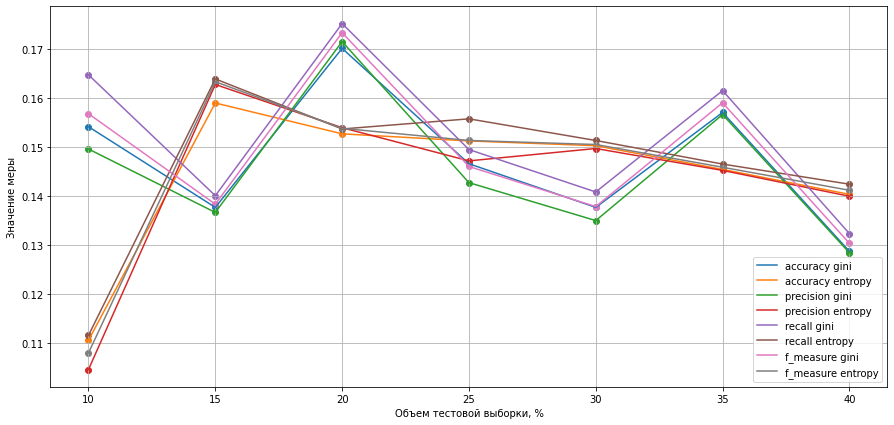

In [3]:
#графическое представление мер
fig, ax = plt.subplots(figsize=(15,7))
for m in ['accuracy', 'precision', 'recall', 'f_measure']:
    for criterion in ['gini', 'entropy']:
        x = result[result.criterion == criterion]['test_size']
        y = result[result.criterion == criterion][m]
        
        f = interp1d(x, y, kind='linear')
        y_smooth=f(x)

        ax.plot (x, y_smooth, label = m + ' ' + criterion)
        ax.scatter (x, y) 
        
        ax.set_xlabel('Объем тестовой выборки, %')
        ax.set_ylabel('Значение меры')
        ax.legend()
    
ax.grid()
plt.show()

In [4]:
#датасет genres_pca_100_comp_of_song.csv   RandomForest

def measure(y_test, y_test_predict, genres):
    #conf matrix
    conf_matrix = pd.DataFrame(np.zeros((12, 12)), index = genres, columns = genres)
    for y, y_p in zip(y_test_predict, y_test):
        conf_matrix.loc[y_p, y] += 1
        
    #accuracy
    accuracy = 0
    for y_p, y in zip(y_test_predict, y_test):
        if y_p == y:
            accuracy += 1
    accuracy /= y_test.shape[0]
    
    #precision
    temp = list()
    for genre in genres:
        temp.append(conf_matrix.loc[genre, genre] / np.sum(conf_matrix.loc[genre, :]))
    precision = np.mean(temp)
    
    #recall
    temp = list()
    for genre in genres:
        temp.append(conf_matrix.loc[genre, genre] / np.sum(conf_matrix.loc[:, genre]))
    recall = np.mean(temp)
    
    #f_measure
    f_measure = 2 * precision * recall / (precision + recall)
  
    return conf_matrix, accuracy, precision, recall, f_measure

if __name__ == '__main__':
    song = pd.read_csv('genres_pca_100_comp_of_song.csv') #genres_pca_mfcc_small.csv
    Y = np.array(song['class'])
    X = np.array(song[[str(i) for i in range(100)]])
    genres = np.unique(Y)
    #print(genres)
    result_table = list()
    for test_size in range(40, 9, -5):
        for criterion in ['gini', 'entropy']:
            print(f'Модель с мощностью обучающей выборки {100 - test_size}%, тестовой выборки {test_size}%')

            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = test_size / 100, shuffle = True, random_state = 42)

            model = ensemble.RandomForestClassifier(random_state=0, criterion = criterion, max_depth = 15, n_estimators = 100)
            model.fit(X_train, y_train)
            
            y_test_predict = model.predict(X_test)
            confusion_matrix, accuracy, precision, recall, f_measure = measure(y_test, y_test_predict, genres)
            print(f'confusion_matrix \n{confusion_matrix}\n accuracy = {accuracy}\n' +
                  f' precision = {precision}\n recall = {recall}\n f_measure = {f_measure}\n')
            result_table.append([criterion, test_size, accuracy, precision, recall, f_measure])

    result = pd.DataFrame(result_table, columns = ['criterion', 'test_size', 'accuracy', 'precision', 'recall', 'f_measure'])
    result.to_csv("result_measure_100rf.csv")
    print(result)    

Модель с мощностью обучающей выборки 60%, тестовой выборки 40%
confusion_matrix 
                allrock  blues  country  electronic  hip-hop  jazz  \
allrock            34.0   16.0      5.0         3.0      7.0   7.0   
blues              17.0   30.0     18.0         2.0      3.0  19.0   
country            21.0   21.0     13.0         2.0      6.0  14.0   
electronic         13.0    3.0      9.0        11.0      6.0  11.0   
hip-hop             9.0    7.0      6.0         2.0     11.0  11.0   
jazz                1.0   11.0      4.0         1.0      3.0  60.0   
latin-american      4.0    6.0      2.0         1.0      4.0  13.0   
pop                 7.0    2.0      3.0         6.0      8.0   4.0   
r-n-b               7.0    9.0     12.0         5.0      8.0   5.0   
reggae              3.0    8.0      6.0         7.0      5.0   8.0   
shanson             2.0    2.0      3.0         1.0      5.0   2.0   
world               6.0   12.0      6.0         3.0      6.0  21.0   

        

confusion_matrix 
                allrock  blues  country  electronic  hip-hop  jazz  \
allrock            17.0   20.0     12.0         4.0     13.0   6.0   
blues              13.0   24.0     20.0         0.0      5.0  17.0   
country             7.0   15.0     12.0         2.0      2.0  15.0   
electronic          7.0    7.0      6.0         8.0      5.0   8.0   
hip-hop             4.0    1.0      6.0         3.0      8.0  10.0   
jazz                2.0    6.0      4.0         2.0      5.0  51.0   
latin-american      3.0    6.0      6.0         1.0      4.0  13.0   
pop                 2.0    0.0      2.0         0.0      9.0   2.0   
r-n-b               5.0    7.0      6.0         1.0      8.0   5.0   
reggae              3.0   10.0      5.0         1.0      6.0  12.0   
shanson             3.0    2.0      5.0         2.0      2.0   2.0   
world               5.0    7.0      9.0         1.0      5.0  10.0   

                latin-american   pop  r-n-b  reggae  shanson  world  
a

confusion_matrix 
                allrock  blues  country  electronic  hip-hop  jazz  \
allrock            17.0   11.0      6.0         3.0      3.0   3.0   
blues               8.0   16.0     12.0         0.0      0.0   6.0   
country             2.0   16.0      3.0         0.0      1.0   3.0   
electronic          6.0    1.0      2.0         1.0      4.0   5.0   
hip-hop             2.0    0.0      4.0         0.0      3.0   4.0   
jazz                0.0    7.0      3.0         0.0      2.0  22.0   
latin-american      2.0    2.0      1.0         0.0      4.0   7.0   
pop                 2.0    0.0      2.0         1.0      2.0   0.0   
r-n-b               2.0    2.0      3.0         2.0      2.0   1.0   
reggae              1.0    1.0      1.0         3.0      2.0   5.0   
shanson             2.0    2.0      0.0         0.0      2.0   2.0   
world               1.0    7.0      1.0         1.0      4.0   4.0   

                latin-american  pop  r-n-b  reggae  shanson  world  
al

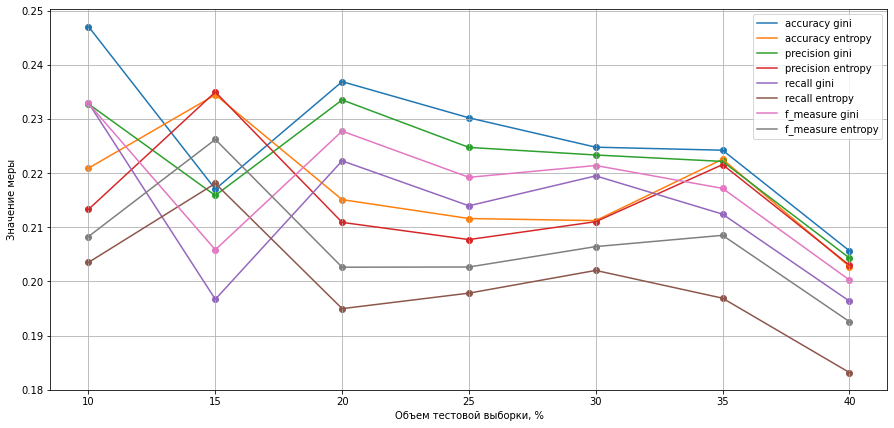

In [5]:
#графическое представление мер
fig, ax = plt.subplots(figsize=(15,7))
for m in ['accuracy', 'precision', 'recall', 'f_measure']:
    for criterion in ['gini', 'entropy']:
        x = result[result.criterion == criterion]['test_size']
        y = result[result.criterion == criterion][m]
        
        f = interp1d(x, y, kind='linear')
        y_smooth=f(x)

        ax.plot (x, y_smooth, label = m + ' ' + criterion)
        ax.scatter (x, y) 
        
        ax.set_xlabel('Объем тестовой выборки, %')
        ax.set_ylabel('Значение меры')
        ax.legend()
    
ax.grid()
plt.show()

In [6]:
#датасет genres_pca_4*12920_comp_of_song.csv (без выделения главных компонент по шкале времени) DecisionTreeClassifier

def measure(y_test, y_test_predict, genres):
    #conf matrix
    conf_matrix = pd.DataFrame(np.zeros((12, 12)), index = genres, columns = genres)
    for y, y_p in zip(y_test_predict, y_test):
        conf_matrix.loc[y_p, y] += 1
        
    #accuracy
    accuracy = 0
    for y_p, y in zip(y_test_predict, y_test):
        if y_p == y:
            accuracy += 1
    accuracy /= y_test.shape[0]
    
    #precision
    temp = list()
    for genre in genres:
        temp.append(conf_matrix.loc[genre, genre] / np.sum(conf_matrix.loc[genre, :]))
    precision = np.mean(temp)
    
    #recall
    temp = list()
    for genre in genres:
        temp.append(conf_matrix.loc[genre, genre] / np.sum(conf_matrix.loc[:, genre]))
    recall = np.mean(temp)
    
    #f_measure
    f_measure = 2 * precision * recall / (precision + recall)
  
    return conf_matrix, accuracy, precision, recall, f_measure

if __name__ == '__main__':
    song = pd.read_csv('genres_pca_4na12920_comp_of_song.csv') #genres_pca_mfcc_small.csv
    Y = np.array(song['class'])
    X = np.array(song[[str(i) for i in range(4*12920)]])
    genres = np.unique(Y)
    #print(genres)
    result_table = list()
    for test_size in range(40, 9, -5):
        for criterion in ['gini', 'entropy']:
            print(f'Модель с мощностью обучающей выборки {100 - test_size}%, тестовой выборки {test_size}%')

            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = test_size / 100, shuffle = True, random_state = 42)

            model = tree.DecisionTreeClassifier(random_state=0, criterion = criterion, max_depth = 15)
            model.fit(X_train, y_train)
            
            # визуализация построенных деревьев решений.
            dot_data = tree.export_graphviz(model, max_depth = 3, out_file=None, class_names=genres, filled=True)
            graph = graphviz.Source(dot_data, format="jpg") 
            graph.render('pictures\\dtree4na12920_render_'+ str(test_size)+'_'+criterion, view=False)
            
            print(f'Глубина построенного дерева решений: {model.get_depth()}')
            y_test_predict = model.predict(X_test)
            confusion_matrix, accuracy, precision, recall, f_measure = measure(y_test, y_test_predict, genres)
            print(f'confusion_matrix \n{confusion_matrix}\n accuracy = {accuracy}\n' +
                  f' precision = {precision}\n recall = {recall}\n f_measure = {f_measure}\n')
            result_table.append([criterion, test_size, accuracy, precision, recall, f_measure])

    result = pd.DataFrame(result_table, columns = ['criterion', 'test_size', 'accuracy', 'precision', 'recall', 'f_measure'])
    result.to_csv("result_measure_4na12920.csv")
    print(result)    

Модель с мощностью обучающей выборки 60%, тестовой выборки 40%
Глубина построенного дерева решений: 15
confusion_matrix 
                allrock  blues  country  electronic  hip-hop  jazz  \
allrock            12.0   27.0     24.0         5.0      8.0   3.0   
blues               7.0   38.0     19.0         4.0      9.0   9.0   
country             9.0   35.0     25.0         6.0      6.0   4.0   
electronic          4.0   30.0     19.0         9.0      9.0   3.0   
hip-hop             7.0   27.0      9.0        10.0      9.0   4.0   
jazz                2.0   28.0     13.0         7.0      8.0  15.0   
latin-american      4.0   29.0     17.0         5.0      5.0   6.0   
pop                 9.0   17.0     10.0         4.0     12.0   4.0   
r-n-b               6.0   25.0     16.0         4.0      6.0   5.0   
reggae              2.0   27.0     21.0         5.0     10.0   4.0   
shanson             3.0   22.0     15.0         3.0     13.0   0.0   
world               5.0   31.0     16.0

Глубина построенного дерева решений: 15
confusion_matrix 
                allrock  blues  country  electronic  hip-hop  jazz  \
allrock            14.0    8.0     12.0        10.0     13.0   4.0   
blues               9.0    8.0     14.0         5.0      4.0   9.0   
country             7.0   13.0      8.0         2.0      9.0   4.0   
electronic          6.0    4.0      9.0         9.0      7.0   6.0   
hip-hop             6.0    2.0      4.0         6.0      2.0   5.0   
jazz                5.0    9.0     13.0         4.0      7.0  18.0   
latin-american      4.0    7.0      7.0         8.0      2.0   7.0   
pop                 6.0    6.0      9.0         4.0      3.0   1.0   
r-n-b              10.0    8.0      6.0         6.0      6.0   4.0   
reggae              4.0    6.0      3.0         3.0      9.0   7.0   
shanson             5.0    2.0      4.0         7.0      4.0   4.0   
world               9.0    9.0     10.0         5.0      8.0   8.0   

                latin-american 

Глубина построенного дерева решений: 15
confusion_matrix 
                allrock  blues  country  electronic  hip-hop  jazz  \
allrock            11.0    4.0      7.0         2.0      4.0   6.0   
blues               3.0    8.0      8.0         4.0      1.0   6.0   
country             3.0    5.0      8.0         6.0      4.0   4.0   
electronic          2.0    2.0     11.0         6.0      3.0   0.0   
hip-hop             2.0    1.0      3.0         3.0      6.0   4.0   
jazz                3.0    5.0      9.0         4.0      5.0   4.0   
latin-american      3.0    2.0      5.0         4.0      7.0   3.0   
pop                 4.0    1.0      4.0         4.0      5.0   1.0   
r-n-b               3.0    4.0      4.0         3.0      5.0   4.0   
reggae              4.0    5.0      1.0         7.0      2.0   2.0   
shanson             1.0    3.0      3.0         4.0      1.0   3.0   
world               2.0    4.0     10.0         5.0      7.0   3.0   

                latin-american 

Глубина построенного дерева решений: 15
confusion_matrix 
                allrock  blues  country  electronic  hip-hop  jazz  \
allrock             5.0    5.0      5.0         6.0      3.0   0.0   
blues               1.0    5.0     11.0         6.0      2.0   1.0   
country             1.0    1.0      8.0         5.0      0.0   0.0   
electronic          3.0    3.0      5.0         4.0      2.0   0.0   
hip-hop             1.0    0.0      4.0         1.0      0.0   2.0   
jazz                4.0    3.0      3.0         1.0      3.0   3.0   
latin-american      5.0    2.0      3.0         2.0      5.0   2.0   
pop                 0.0    1.0      3.0         1.0      2.0   0.0   
r-n-b               2.0    2.0      2.0         2.0      3.0   0.0   
reggae              0.0    1.0      3.0         3.0      2.0   1.0   
shanson             0.0    0.0      2.0         3.0      1.0   1.0   
world               2.0    2.0      8.0         2.0      0.0   2.0   

                latin-american 

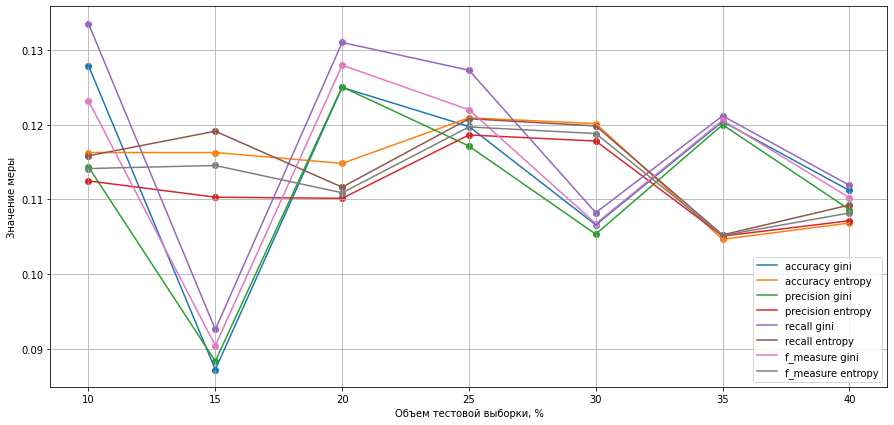

In [7]:
#графическое представление мер
fig, ax = plt.subplots(figsize=(15,7))
for m in ['accuracy', 'precision', 'recall', 'f_measure']:
    for criterion in ['gini', 'entropy']:
        x = result[result.criterion == criterion]['test_size']
        y = result[result.criterion == criterion][m]
        
        f = interp1d(x, y, kind='linear')
        y_smooth=f(x)

        ax.plot (x, y_smooth, label = m + ' ' + criterion)
        ax.scatter (x, y) 
        
        ax.set_xlabel('Объем тестовой выборки, %')
        ax.set_ylabel('Значение меры')
        ax.legend()
    
ax.grid()
plt.show()

In [8]:
#датасет genres_pca_4*12920_comp_of_song.csv   RandomForest

def measure(y_test, y_test_predict, genres):
    #conf matrix
    conf_matrix = pd.DataFrame(np.zeros((12, 12)), index = genres, columns = genres)
    for y, y_p in zip(y_test_predict, y_test):
        conf_matrix.loc[y_p, y] += 1
        
    #accuracy
    accuracy = 0
    for y_p, y in zip(y_test_predict, y_test):
        if y_p == y:
            accuracy += 1
    accuracy /= y_test.shape[0]
    
    #precision
    temp = list()
    for genre in genres:
        temp.append(conf_matrix.loc[genre, genre] / np.sum(conf_matrix.loc[genre, :]))
    precision = np.mean(temp)
    
    #recall
    temp = list()
    for genre in genres:
        temp.append(conf_matrix.loc[genre, genre] / np.sum(conf_matrix.loc[:, genre]))
    recall = np.mean(temp)
    
    #f_measure
    f_measure = 2 * precision * recall / (precision + recall)
  
    return conf_matrix, accuracy, precision, recall, f_measure

if __name__ == '__main__':
    song = pd.read_csv('genres_pca_4na12920_comp_of_song.csv') #genres_pca_mfcc_small.csv
    Y = np.array(song['class'])
    X = np.array(song[[str(i) for i in range(4*12920)]])
    genres = np.unique(Y)
    #print(genres)
    result_table = list()
    for test_size in range(40, 9, -5):
        for criterion in ['gini', 'entropy']:
            print(f'Модель с мощностью обучающей выборки {100 - test_size}%, тестовой выборки {test_size}%')

            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = test_size / 100, shuffle = True, random_state = 42)

            model = ensemble.RandomForestClassifier(random_state=0, criterion = criterion, max_depth = 15, n_estimators = 100)
            model.fit(X_train, y_train)
            
            y_test_predict = model.predict(X_test)
            confusion_matrix, accuracy, precision, recall, f_measure = measure(y_test, y_test_predict, genres)
            print(f'confusion_matrix \n{confusion_matrix}\n accuracy = {accuracy}\n' +
                  f' precision = {precision}\n recall = {recall}\n f_measure = {f_measure}\n')
            result_table.append([criterion, test_size, accuracy, precision, recall, f_measure])

    result = pd.DataFrame(result_table, columns = ['criterion', 'test_size', 'accuracy', 'precision', 'recall', 'f_measure'])
    result.to_csv("result_measure_4na12920rf.csv")
    print(result)  

Модель с мощностью обучающей выборки 60%, тестовой выборки 40%
confusion_matrix 
                allrock  blues  country  electronic  hip-hop  jazz  \
allrock            41.0   10.0     10.0         4.0      7.0   7.0   
blues              26.0   22.0     15.0         0.0      4.0  22.0   
country            21.0   15.0     15.0         4.0      0.0  15.0   
electronic         15.0    6.0      8.0        14.0      7.0  14.0   
hip-hop             8.0    2.0      6.0        13.0      9.0   8.0   
jazz                3.0   11.0      5.0         1.0      2.0  64.0   
latin-american      5.0    6.0      5.0         5.0      8.0  14.0   
pop                 8.0    1.0      5.0         7.0      8.0   2.0   
r-n-b               9.0   10.0      8.0         2.0     12.0   8.0   
reggae              4.0    6.0      3.0         9.0     10.0  10.0   
shanson            15.0    2.0      4.0         1.0      3.0   1.0   
world               9.0    4.0      5.0         5.0      4.0  23.0   

        

confusion_matrix 
                allrock  blues  country  electronic  hip-hop  jazz  \
allrock            31.0    8.0     15.0         7.0      4.0   7.0   
blues              15.0   23.0     15.0         1.0      1.0  18.0   
country            13.0   12.0     22.0         4.0      2.0  13.0   
electronic         13.0    5.0     12.0         6.0      1.0  11.0   
hip-hop             6.0    4.0     13.0         5.0      5.0  11.0   
jazz                0.0   11.0      6.0         1.0      1.0  49.0   
latin-american      8.0    6.0      3.0         5.0      8.0  12.0   
pop                 2.0    2.0      5.0         1.0     10.0   3.0   
r-n-b               4.0    5.0      3.0         5.0      3.0  11.0   
reggae              0.0    6.0      5.0         3.0     11.0  14.0   
shanson             2.0    0.0      6.0         5.0      4.0   4.0   
world               7.0    9.0      7.0         3.0      7.0  15.0   

                latin-american   pop  r-n-b  reggae  shanson  world  
a

confusion_matrix 
                allrock  blues  country  electronic  hip-hop  jazz  \
allrock            18.0    5.0      6.0         6.0      2.0   3.0   
blues              10.0    9.0      9.0         3.0      1.0   8.0   
country             5.0    6.0     12.0         0.0      2.0   4.0   
electronic         11.0    1.0      2.0         7.0      6.0   4.0   
hip-hop             1.0    1.0      2.0         1.0      4.0   4.0   
jazz                0.0    3.0      4.0         0.0      3.0  25.0   
latin-american      1.0    2.0      7.0         4.0      2.0   7.0   
pop                 3.0    1.0      5.0         1.0      1.0   0.0   
r-n-b               4.0    4.0      3.0         1.0      6.0   2.0   
reggae              2.0    2.0      0.0         5.0      3.0   1.0   
shanson             1.0    1.0      3.0         0.0      1.0   0.0   
world               4.0    0.0      7.0         1.0      2.0   8.0   

                latin-american  pop  r-n-b  reggae  shanson  world  
al

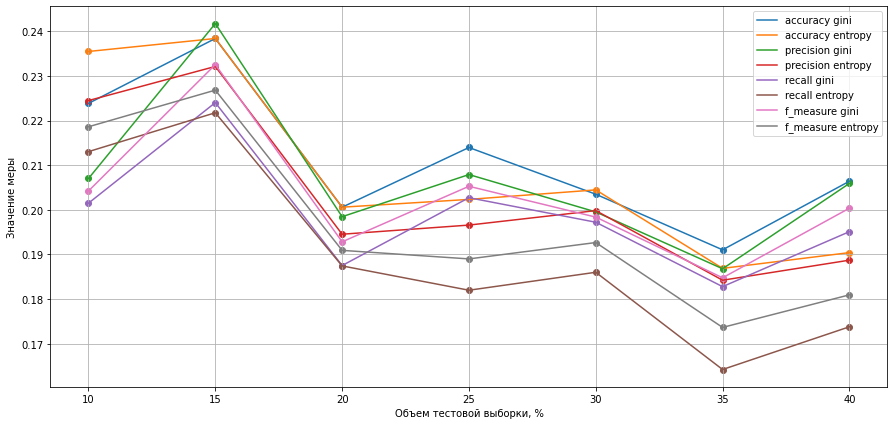

In [9]:
#графическое представление мер
fig, ax = plt.subplots(figsize=(15,7))
for m in ['accuracy', 'precision', 'recall', 'f_measure']:
    for criterion in ['gini', 'entropy']:
        x = result[result.criterion == criterion]['test_size']
        y = result[result.criterion == criterion][m]
        
        f = interp1d(x, y, kind='linear')
        y_smooth=f(x)

        ax.plot (x, y_smooth, label = m + ' ' + criterion)
        ax.scatter (x, y) 
        
        ax.set_xlabel('Объем тестовой выборки, %')
        ax.set_ylabel('Значение меры')
        ax.legend()
    
ax.grid()
plt.show()